In [200]:
#reset variables and clear memory
reset -f

NameError: name 'reset' is not defined

In [201]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import string
from sklearn.model_selection import train_test_split
from copy import deepcopy
from sklearn.preprocessing import Normalizer
from scipy import ndimage
from skimage import measure
from keras.models import Sequential
from keras import metrics
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from keras import Input
from keras.layers import Concatenate
from keras.layers import concatenate
from keras import Model


In [202]:
#Entire images and labels extracted for training
images_train = np.load('../../Kaggle_data/train_images.npy', encoding='latin1')
IMAGE_TRAIN = deepcopy(images_train)
IMAGE_TRAIN = IMAGE_TRAIN[:,1]
IMAGE_TRAIN = IMAGE_TRAIN.tolist()
images_train = images_train[:,1]
images_train = images_train.tolist()

for i in range(len(images_train)):
    images_train[i]=images_train[i].reshape(100,100)
    
for i in range(len(IMAGE_TRAIN)):
    IMAGE_TRAIN[i] = IMAGE_TRAIN[i].reshape(100,100)

with open('../../Kaggle_data/train_labels.csv') as f:
    reader = csv.reader(f, delimiter=",")
    label_train = list(reader)   
del label_train[0]


In [ ]:
#Images extracted for testing
images_test = np.load('../../Kaggle_data/test_images.npy', encoding='latin1')
IMAGE_TEST = deepcopy(images_test)
IMAGE_TEST = IMAGE_TEST[:,1]
IMAGE_TEST = IMAGE_TEST.tolist()
images_test = images_test[:,1]
images_test = images_test.tolist()

for i in range(len(images_test)):
    images_test[i]=images_test[i].reshape(100,100)
    
for i in range(len(IMAGE_TEST)):
    IMAGE_TEST[i] = IMAGE_TEST[i].reshape(100,100)

In [4]:
#FOR TRAINING SET
#Carve around contours with maximum length. Noise around any enclosed contour is removed
contour=[]
image_crop = []
# for j in range(1000):
for j in range(len(images_train)):
    contour.append(measure.find_contours(images_train[j],0.1))
    c=0
    for n,i in enumerate(contour[j]):
        if len(i)>c:
            c = len(i)
            idx = n
    r_mask = np.zeros_like(images_train[j],dtype='bool')
    r_mask[np.round(contour[j][idx][:, 0]).astype('int'), np.round(contour[j][idx][:, 1]).astype('int')] = 1
    r_mask = ndimage.binary_fill_holes(r_mask)
    for k in range(0,r_mask.shape[0]):
        for l in range(0,r_mask.shape[1]):
            if r_mask[k,l]==0:
                images_train[j][k,l] = 0
    ymin = int(round(min(contour[j][idx][:,0])))
    xmin = int(round(min(contour[j][idx][:,1])))
    ymax = int(round(max(contour[j][idx][:,0])))
    xmax = int(round(max(contour[j][idx][:,1])))
    image_crop.append(images_train[j][ymin+1:ymax-1,xmin+1:xmax-1])

In [328]:
#FOR TEST SET
#Carve around contours with maximum length. Noise around any enclosed contour is removed
contour_test=[]
image_crop_test = []
# for j in range(1000):
for j in range(len(images_test)):
    contour_test.append(measure.find_contours(images_test[j],0.1))
    c=0
    for n,i in enumerate(contour_test[j]):
        if len(i)>c:
            c = len(i)
            idx = n
    r_mask = np.zeros_like(images_test[j],dtype='bool')
    r_mask[np.round(contour_test[j][idx][:, 0]).astype('int'), np.round(contour_test[j][idx][:, 1]).astype('int')] = 1
    r_mask = ndimage.binary_fill_holes(r_mask)
    for k in range(0,r_mask.shape[0]):
        for l in range(0,r_mask.shape[1]):
            if r_mask[k,l]==0:
                images_test[j][k,l] = 0
    ymin = int(round(min(contour_test[j][idx][:,0])))
    xmin = int(round(min(contour_test[j][idx][:,1])))
    ymax = int(round(max(contour_test[j][idx][:,0])))
    xmax = int(round(max(contour_test[j][idx][:,1])))
    image_crop_test.append(images_test[j][ymin+1:ymax-1,xmin+1:xmax-1])

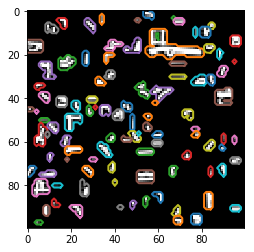

In [5]:
#Show the contours of an image from training set
image1 = IMAGE_TRAIN[1]

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(image1, interpolation='nearest', cmap=plt.cm.gray)

for n, i in enumerate(contour[1]):
    ax.plot(i[:, 1], i[:, 0], linewidth=2)

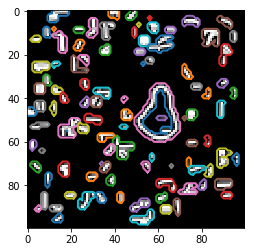

In [285]:
#Show the contours of an image from test set
image1 = IMAGE_TEST[1]

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(image1, interpolation='nearest', cmap=plt.cm.gray)

for n, i in enumerate(contour_test[1]):
    ax.plot(i[:, 1], i[:, 0], linewidth=2)

In [6]:
#FOR TRAINING SET
#Extract height, width, edges, gradient, and gradient direction from cropped image 
from skimage.transform import resize
from scipy.ndimage import gaussian_filter
from skimage import feature

image_size = []
image_norm = []
image_norm_new = []
ver_grad = []
hor_grad = []
ver_max = []
hor_max = []
grad_mag = []
grad_mag_norm = []
edge_angle_norm = []
transformer = Normalizer()

for i in image_crop:
    image_size.append(i.size)
    image_norm.append(resize(i,(30,30), anti_aliasing = True, mode='constant'))
    image_norm_new.append(transformer.transform(resize(i,(30,30), anti_aliasing = True, mode='constant')))
for i in image_norm:
    v_grad = np.pad(i,((1,0),(0,0)),mode='constant')
    ve_grad = np.diff(v_grad,axis=0)
    ver_grad.append(ve_grad)
    h_grad = np.pad(i,((0,0),(1,0)),mode='constant')
    ho_grad = np.diff(h_grad,axis=1)
    hor_grad.append(ho_grad)
    for i in range(0,ho_grad.shape[0]):
        for j in range(0,ho_grad.shape[1]):
            if ho_grad[i,j]>ho_grad[i,j-1]:
                ho_grad[i,j-1]=0
            else:
                    ho_grad[i,j]=0
    hor_max.append(ho_grad)
    for i in range(0,ve_grad.shape[0]):
        for j in range(0,ve_grad.shape[1]):
            if ve_grad[i,j]>ho_grad[i-1,j]:
                ve_grad[i-1,j]=0
            else:
                    ve_grad[i,j]=0
    ver_max.append(ve_grad)
    grad_magni = ve_grad+ho_grad
    for i in range(0,grad_magni.shape[0]):
        for j in range(0,grad_magni.shape[1]):
            if grad_magni[i,j] > 0:
                grad_magni[i,j]=255
    grad_mag.append(grad_magni)
    grad_mag_norm.append(transformer.transform(grad_magni))

#Gradient angle
edge_angle=[]
for i in range(len(hor_grad)):
    edge_angle.append(np.arctan2(hor_grad[i], ver_grad[i]))
    edge_angle_norm.append(transformer.transform(np.arctan2(hor_grad[i], ver_grad[i])))

In [329]:
#FOR TESTING
#Extract height, width, edges, gradient, and gradient direction from cropped image 
from skimage.transform import resize
from scipy.ndimage import gaussian_filter
from skimage import feature

image_size_test = []
image_norm_test = []
ver_grad_test = []
hor_grad_test = []
ver_max_test = []
hor_max_test = []
image_norm_new_test = []
grad_mag_test = []
for i in image_crop_test:
    image_size_test.append(i.size)
    image_norm_test.append(resize(i,(30,30), anti_aliasing = True, mode='constant'))
    image_norm_new_test.append(transformer.transform(resize(i,(30,30), anti_aliasing = True, mode='constant')))

for i in image_norm_test:
    v_grad_test = np.pad(i,((1,0),(0,0)),mode='constant')
    ve_grad_test = np.diff(v_grad_test,axis=0)
    ver_grad_test.append(ve_grad_test)
    h_grad_test = np.pad(i,((0,0),(1,0)),mode='constant')
    ho_grad_test = np.diff(h_grad_test,axis=1)
    hor_grad_test.append(ho_grad_test)
    for i in range(0,ho_grad_test.shape[0]):
        for j in range(0,ho_grad_test.shape[1]):
            if ho_grad_test[i,j]>ho_grad_test[i,j-1]:
                ho_grad_test[i,j-1]=0
            else:
                    ho_grad_test[i,j]=0
    hor_max_test.append(ho_grad_test)
    for i in range(0,ve_grad_test.shape[0]):
        for j in range(0,ve_grad_test.shape[1]):
            if ve_grad_test[i,j]>ho_grad_test[i-1,j]:
                ve_grad_test[i-1,j]=0
            else:
                    ve_grad_test[i,j]=0
    ver_max_test.append(ve_grad_test)
    grad_magni_test = ve_grad_test+ho_grad_test
    for i in range(0,grad_magni_test.shape[0]):
        for j in range(0,grad_magni_test.shape[1]):
            if grad_magni_test[i,j] > 0:
                grad_magni_test[i,j]=255
    grad_mag_test.append(grad_magni_test)

#Gradient angle
edge_angle_test=[]
for i in range(len(hor_grad_test)):
    edge_angle_test.append(np.arctan2(hor_grad_test[i], ver_grad_test[i]))

In [7]:
#FOR TRAINING SET
#Make a list that consists of the size of image and edge angle information

edge_angle_row=[]
for i in range(len(edge_angle)):
    edge_angle_row.append(edge_angle[i].reshape(edge_angle[i].size))
    edge_angle_row[i] = [image_size[i]]+edge_angle_row[i].tolist()
with open('processed_train.txt', 'w') as f:
    for item in edge_angle_row:
        f.write("%s\n" % item)

In [307]:
#FOR TEST SET
#Make a list that consists of the size of image and edge angle information

edge_angle_row_test=[]
for i in range(len(edge_angle_test)):
    edge_angle_row_test.append(edge_angle_test[i].reshape(edge_angle_test[i].size))
    edge_angle_row_test[i] = [image_size_test[i]]+edge_angle_row_test[i].tolist()
with open('processed_test.txt', 'w') as f:
    for item in edge_angle_row_test:
        f.write("%s\n" % item)

['4691', 'skull']
621


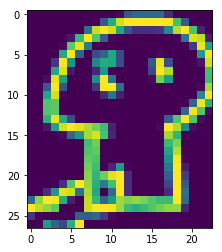

In [131]:
#Display processed sample image from training set, its label, and size

i=4691
plt.imshow(image_crop[i])
print(label_train[i])
print(image_crop[i].size)


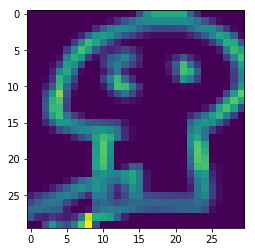

In [133]:
#normalized image
plt.imshow(image_norm_new[i])

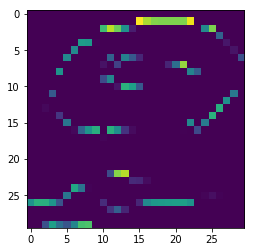

In [134]:
plt.imshow(ver_grad[i])

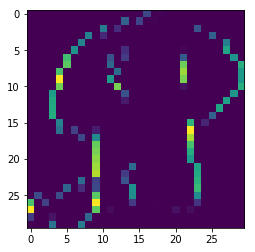

In [135]:
plt.imshow(hor_grad[i])

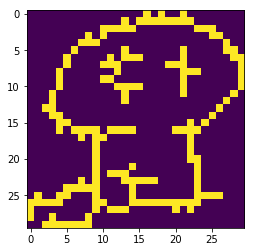

In [136]:
plt.imshow(grad_mag[i])

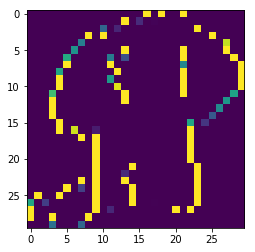

In [137]:
plt.imshow(edge_angle[i])

In [139]:
#One hot encoding of labels
label_dic = {'shovel':0,
       'rifle':1,
       'scorpion':2,
       'apple':3,
       'spoon':4,
       'pineapple':5,
       'mouth':6,
       'skateboard':7,
       'rollerskates':8,
       'peanut':9,
       'rabbit':10,
       'sink':11,
       'sailboat':12,
       'nose':13,
       'skull':14,
       'pool':15,
       'pear':16,
       'pillow':17,
       'penguin':18,
       'nail':19,
       'pencil':20,
       'empty':21,
       'moustache':22,
       'paintbrush':23,
       'panda':24,
       'parrot':25,
       'screwdriver':26,
       'squiggle':27,
       'octagon':28,
       'rhinoceros':29,
       'mug':30}

label_dic_copy = deepcopy(label_dic) 

#make one hot encoding dictionary in this loop
for key, value in label_dic.items():
    new_value = np.zeros(31)
    new_value[value] = 1
    label_dic[key] = new_value

label_encoded = np.zeros([np.shape(label_train)[0],31])

#make one hot encoded array of training labels
for i in range(np.shape(label_train)[0]):
    label_encoded[i] = label_dic[label_train[i][1]] 


In [141]:
#Encoded label dictionary
label_dic

{'shovel': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'rifle': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'scorpion': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'apple': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'spoon': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'pineapple': array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'mouth': array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 

# CNN Implementation

## Hold-out Validation (Cross Validation option below)

In [194]:
#Using image and image size as features to CNN
image_norm_new_arr = np.asarray(image_norm_new) #gives best results
image_size_arr = np.asarray(image_size)
image_size_norm_arr = transformer.transform(image_size_arr.reshape(1,-1))

#Images
X_train, X_valid, y_train, y_valid = train_test_split(image_norm_new_arr, label_encoded, test_size=0.2, random_state=42) 

#Image size
X_train2, X_valid2, _, _ = train_test_split(image_size_norm_arr.ravel(), label_encoded, test_size=0.2, random_state=42) 

X_train = X_train.reshape(np.shape(X_train)[0],30,30,1)
X_valid = X_valid.reshape(np.shape(X_valid)[0],30,30,1)

#create CNN model

#0.65 accuracy
# model = Sequential()
# model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(30,30,1)))
# model.add(Conv2D(32, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(31, activation='softmax'))

#0.67
# model = Sequential()
# model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(30,30,1)))
# model.add(Conv2D(32, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# # model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(31, activation='softmax'))

#0.68 (150 epochs)
# model = Sequential()
# model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(30,30,1)))
# model.add(LeakyReLU(alpha=0.1))
# model.add(MaxPooling2D((2, 2),padding='same'))
# model.add(Dropout(0.25))
# model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
# model.add(LeakyReLU(alpha=0.1))
# model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
# model.add(Dropout(0.25))
# model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
# model.add(LeakyReLU(alpha=0.1))                  
# model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
# model.add(Dropout(0.4))
# model.add(Flatten())
# model.add(Dense(128, activation='linear'))
# model.add(LeakyReLU(alpha=0.1))           
# model.add(Dropout(0.3))
# model.add(Dense(31, activation='softmax'))

#0.69 (150 epochs)
# model = Sequential()
# model.add(Conv2D(32, kernel_size=(3, 3), strides=1,activation='linear',padding='same',input_shape=(30,30,1)))
# model.add(LeakyReLU(alpha=0.1))
# model.add(MaxPooling2D((2, 2),padding='same'))
# model.add(Dropout(0.25))
# model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
# model.add(LeakyReLU(alpha=0.1))
# model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
# model.add(Dropout(0.25))
# model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
# model.add(LeakyReLU(alpha=0.1))                  
# model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
# model.add(Dropout(0.4))
# model.add(Flatten())
# model.add(Dense(128, activation='linear'))
# model.add(LeakyReLU(alpha=0.1))           
# model.add(Dropout(0.3))
# model.add(Dense(31, activation='softmax'))


# model = Sequential()
# model.add(Conv2D(32, (5, 5), input_shape=(30,30,1), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
# model.add(Conv2D(64, (5, 5), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.6))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.6))
# model.add(Dense(31, activation='softmax'))

#0.7 accuracy (considers both the image and the image size)
images = Input(shape = (30,30,1), name = 'Images')
size = Input(shape = (1,), name = 'Size')

conv = Sequential()

conv.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(30,30,1)))
conv.add(LeakyReLU(alpha=0.1))
conv.add(MaxPooling2D((2, 2),padding='same'))
conv.add(Dropout(0.25))
conv.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
conv.add(LeakyReLU(alpha=0.1))
conv.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
conv.add(Dropout(0.25))
conv.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
conv.add(LeakyReLU(alpha=0.1))                  
conv.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
conv.add(Dropout(0.4))
conv.add(Flatten())
part1 = conv(images)

merged = concatenate([part1, size])

final = Dense(128, activation='linear')(merged)
final = LeakyReLU(alpha=0.1)(final)
final = Dropout(0.3)(final)
final = Dense(31, activation='softmax')(final)

model = Model(inputs=[images, size], outputs=[final])



model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [197]:
#train the model
# history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=15) #just images
history = model.fit([X_train, np.array(X_train2)], y_train, validation_data=([X_valid, X_valid2], y_valid), epochs=15) #images + size

Train on 8000 samples, validate on 2000 samples
Epoch 1/15
8000/8000 [==============================] - 15s 2ms/step - loss: 0.9823 - acc: 0.7045 - val_loss: 1.2807 - val_acc: 0.6565
Epoch 2/15
8000/8000 [==============================] - 17s 2ms/step - loss: 0.9443 - acc: 0.7183 - val_loss: 1.2608 - val_acc: 0.6610
Epoch 3/15
8000/8000 [==============================] - 17s 2ms/step - loss: 0.8950 - acc: 0.7334 - val_loss: 1.2630 - val_acc: 0.6555
Epoch 4/15
8000/8000 [==============================] - 17s 2ms/step - loss: 0.8584 - acc: 0.7448 - val_loss: 1.2670 - val_acc: 0.6490
Epoch 5/15
8000/8000 [==============================] - 17s 2ms/step - loss: 0.8141 - acc: 0.7505 - val_loss: 1.2374 - val_acc: 0.6645
Epoch 6/15
8000/8000 [==============================] - 18s 2ms/step - loss: 0.8030 - acc: 0.7515 - val_loss: 1.2892 - val_acc: 0.6545
Epoch 7/15
8000/8000 [==============================] - 17s 2ms/step - loss: 0.7638 - acc: 0.7631 - val_loss: 1.2899 - val_acc: 0.6635
Epoch 8

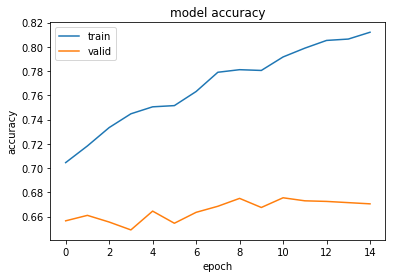

In [198]:
#plots
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

### Doing full training with tuned hyperparameters and predicting test labels

In [157]:
image_norm_new_arr = np.asarray(image_norm_new) 
image_norm_new_test_arr = np.asarray(image_norm_new_test)

X_train = image_norm_new_arr #Use ALL the training data
y_train = label_encoded
X_test = image_norm_new_test_arr

X_train = X_train.reshape(np.shape(X_train)[0],30,30,1)
X_test = X_test.reshape(np.shape(X_test)[0],30,30,1)

#create model
images = Input(shape = (30,30,1), name = 'Images')
size = Input(shape = (1,), name = 'Size')

conv = Sequential()

conv.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(30,30,1)))
conv.add(LeakyReLU(alpha=0.1))
conv.add(MaxPooling2D((2, 2),padding='same'))
conv.add(Dropout(0.25))
conv.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
conv.add(LeakyReLU(alpha=0.1))
conv.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
conv.add(Dropout(0.25))
conv.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
conv.add(LeakyReLU(alpha=0.1))                  
conv.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
conv.add(Dropout(0.4))
conv.add(Flatten())
part1 = conv(images)

merged = concatenate([part1, size])

final = Dense(128, activation='linear')(merged)
final = LeakyReLU(alpha=0.1)(final)
final = Dropout(0.3)(final)
final = Dense(31, activation='softmax')(final)

model = Model(inputs=[images, size], outputs=[final])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

NameError: name 'image_norm_new_test' is not defined

In [334]:
#train the model
# model.fit(X_train, y_train, epochs=100)
history = model.fit([X_train, np.array(X_train2)], y_train, epochs=150) #images + size

Epoch 1/70
10000/10000 [==============================] - 19s 2ms/step - loss: 1.4453 - acc: 0.5915
Epoch 2/70
10000/10000 [==============================] - 20s 2ms/step - loss: 1.3280 - acc: 0.6212
Epoch 3/70
10000/10000 [==============================] - 20s 2ms/step - loss: 1.2461 - acc: 0.6436
Epoch 4/70
10000/10000 [==============================] - 20s 2ms/step - loss: 1.1792 - acc: 0.6607
Epoch 5/70
10000/10000 [==============================] - 20s 2ms/step - loss: 1.1076 - acc: 0.6804
Epoch 6/70
10000/10000 [==============================] - 20s 2ms/step - loss: 1.0616 - acc: 0.6914
Epoch 7/70
10000/10000 [==============================] - 20s 2ms/step - loss: 1.0133 - acc: 0.6990
Epoch 8/70
10000/10000 [==============================] - 20s 2ms/step - loss: 0.9582 - acc: 0.7152
Epoch 9/70
10000/10000 [==============================] - 20s 2ms/step - loss: 0.9349 - acc: 0.7220
Epoch 10/70
10000/10000 [==============================] - 20s 2ms/step - loss: 0.8894 - acc: 0.7338

In [ ]:
#validation accuracy of fully trained CNN
model.evaluate(X_valid,y_valid)

In [369]:
#Prediction of test labels
pred_classes = model.predict_classes(X_test)
pred_classes

array([ 5, 16, 11, ...,  7,  5, 30])

In [408]:
#converting predicted classes to actual labels for saving to CSV
pred_labels = [['Id', 'Category']]

for i in range(len(pred_classes)):
    for key, value in label_dic_copy.items():
        if value == pred_classes[i]:
            temp = [i,key]
            pred_labels.append(temp)

pred_labels = np.asarray(pred_labels)
# pred_labels.tofile('foo.csv',sep=',', newline = ' ')
# with open('foo.txt', 'w') as f:
#     writer = csv.writer(f, dialect='excel')
#     writer.writerow(pred_labels)

df = pd.DataFrame(pred_labels)
df.to_csv("CNN.csv", header = None, index = None)


In [407]:
pred_labels

array([['Id', 'Category'],
       ['0', 'pineapple'],
       ['1', 'pear'],
       ...,
       ['9997', 'skateboard'],
       ['9998', 'pineapple'],
       ['9999', 'mug']], dtype='<U12')

prediction:  parrot
525


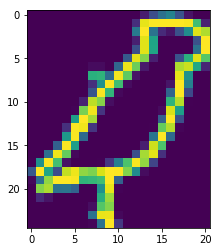

In [445]:
#Test image with predicted label from CNN
i=34

print("prediction: ",pred_labels[i+1][1])
plt.imshow(image_crop_test[i])
# print(label_test[i])
print(image_crop_test[i].size)

## K-Fold Cross Validation (optional)

In [149]:
# image_norm_arr = np.asarray(image_norm)
image_norm_new_arr = np.asarray(image_norm_new)
X = image_norm_new_arr
# X = image_norm_arr
y = label_encoded
splits = 5    # Number of folds
kf = KFold(n_splits=splits)
kf.get_n_splits(X)
fold = 0
acc_arr = []

for train_index, test_index in kf.split(X):
    
    fold = fold + 1
    print("Fold: ", fold)
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train = X_train.reshape(np.shape(X_train)[0],30,30,1)
    X_test = X_test.reshape(np.shape(X_test)[0],30,30,1)
    
    #create model
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), strides=1,activation='linear',padding='same',input_shape=(30,30,1)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D((2, 2),padding='same'))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
    model.add(LeakyReLU(alpha=0.1))                  
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='linear'))
    model.add(LeakyReLU(alpha=0.1))           
    model.add(Dropout(0.3))
    model.add(Dense(31, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    #train the model
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1)
    
    acc = model.evaluate(X_test, y_test, verbose=0)[1]
    acc_arr.append(acc)
    print("Accuracy of Fold: ", acc)
    print("")
avg_acc = np.mean(acc_arr)
print("K-Fold Average Accuracy: ", avg_acc)

Fold:  1
Train on 8000 samples, validate on 2000 samples
Epoch 1/1
8000/8000 [==============================] - 15s 2ms/step - loss: 2.8620 - acc: 0.2120 - val_loss: 2.2469 - val_acc: 0.3890
Accuracy of Fold:  0.389
Fold:  2
Train on 8000 samples, validate on 2000 samples
Epoch 1/1
8000/8000 [==============================] - 20s 3ms/step - loss: 2.8818 - acc: 0.2151 - val_loss: 2.2952 - val_acc: 0.3775
Accuracy of Fold:  0.3775
Fold:  3
Train on 8000 samples, validate on 2000 samples
Epoch 1/1
8000/8000 [==============================] - 20s 3ms/step - loss: 2.8208 - acc: 0.2254 - val_loss: 2.1658 - val_acc: 0.4220
Accuracy of Fold:  0.422
Fold:  4
Train on 8000 samples, validate on 2000 samples
Epoch 1/1
8000/8000 [==============================] - 21s 3ms/step - loss: 2.8421 - acc: 0.2186 - val_loss: 2.2508 - val_acc: 0.3805
Accuracy of Fold:  0.3805
Fold:  5
Train on 8000 samples, validate on 2000 samples
Epoch 1/1
8000/8000 [==============================] - 20s 3ms/step - loss: 2